In [117]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

In [118]:
dataset_folder = './datasets/train_zip/train'

In [119]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

image_files = {
    'filename': [],
    'width': [],
    'height': [],
}

In [125]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None

    with Image.open(file_path) as img:
        width, height = img.size

    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    return width, height

def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width, height = get_image_dimensions(xml_file, dataset_folder + "/" + filename)

    image_files['filename'].append(filename)
    image_files['width'].append(width)
    image_files['height'].append(height)

    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        data['filename'].append(filename)
        data['width'].append(width)
        data['height'].append(height)
        data['class'].append(obj_class)
        data['xmin'].append(xmin)
        data['ymin'].append(ymin)
        data['xmax'].append(xmax)
        data['ymax'].append(ymax)

In [126]:
for file in os.listdir(dataset_folder):
    if file.endswith(".xml"):
        parse_xml(os.path.join(dataset_folder, file))

In [127]:
mixed_filenames = df[df['filename'].str.contains('mixed', case=False, na=False)]['class']

In [129]:
df = pd.DataFrame(data)
image_files_df = pd.DataFrame(image_files)

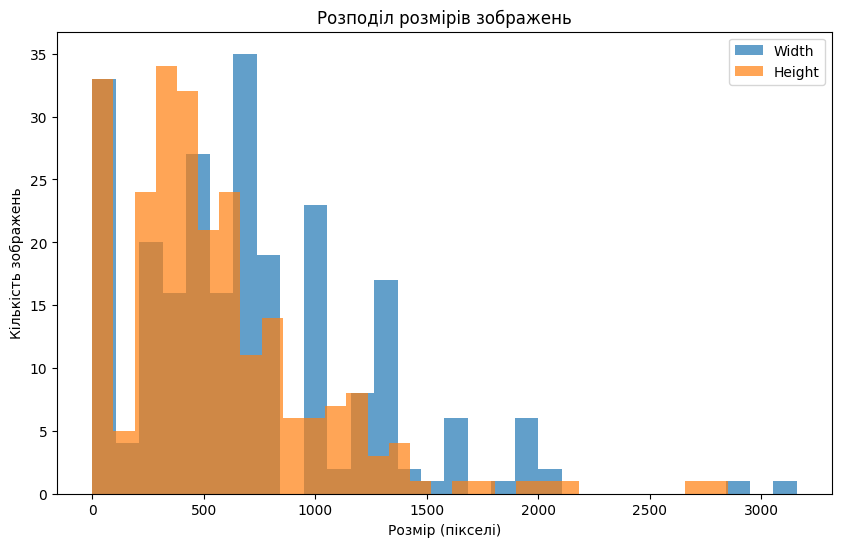

In [106]:
plt.figure(figsize=(10, 6))
plt.hist(image_files_df['width'], bins=30, alpha=0.7, label='Width')
plt.hist(image_files_df['height'], bins=30, alpha=0.7, label='Height')
plt.xlabel('Розмір (пікселі)')
plt.ylabel('Кількість зображень')
plt.title('Розподіл розмірів зображень')
plt.legend()
plt.show()

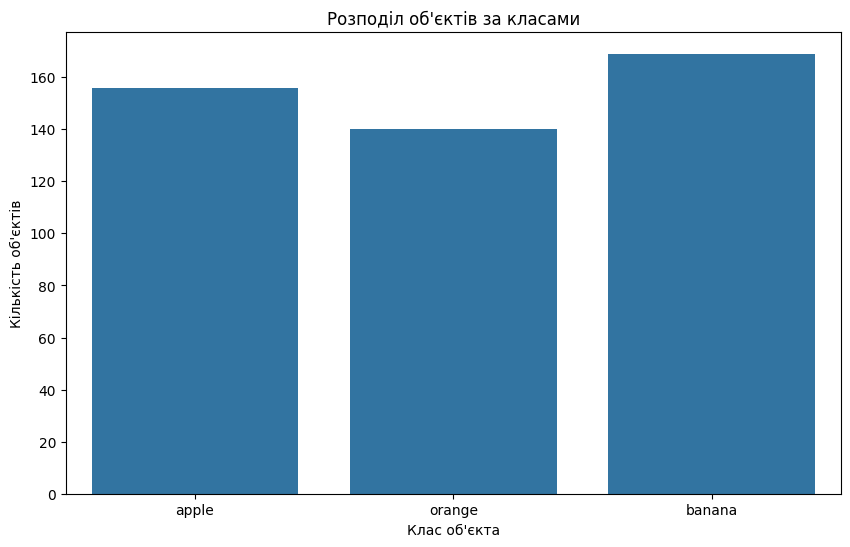

In [91]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df)
plt.title('Розподіл об\'єктів за класами')
plt.xlabel('Клас об\'єкта')
plt.ylabel('Кількість об\'єктів')
plt.show()

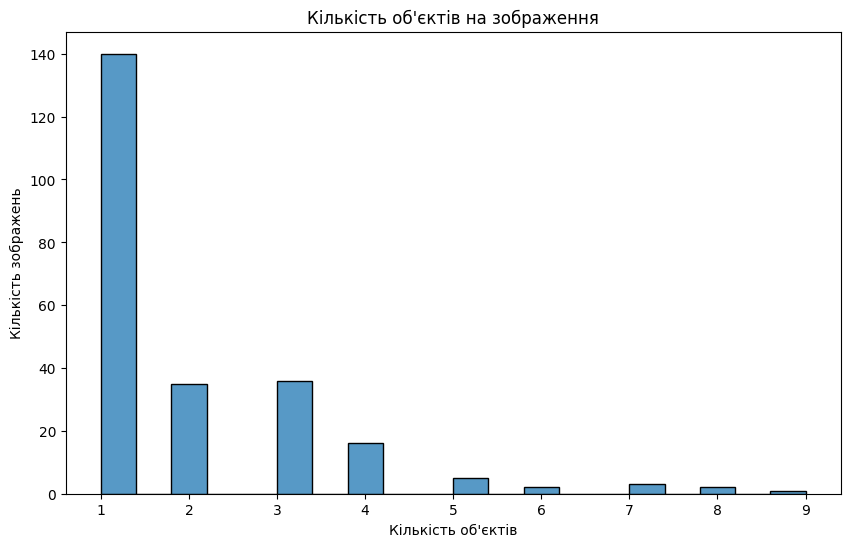

In [92]:
objects_per_image = df.groupby('filename')['class'].count().reset_index(name='object_count')

plt.figure(figsize=(10, 6))
sns.histplot(objects_per_image['object_count'], bins=20, kde=False)
plt.title('Кількість об\'єктів на зображення')
plt.xlabel('Кількість об\'єктів')
plt.ylabel('Кількість зображень')
plt.show()

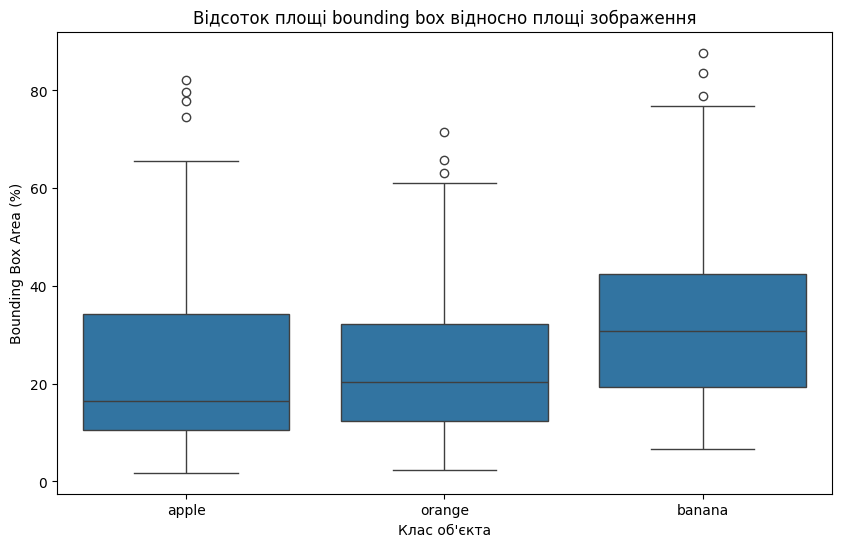

In [93]:
df['image_area'] = df['width'] * df['height']
df['bbox_area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
df['bbox_percentage'] = (df['bbox_area'] / df['image_area']) * 100

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='bbox_percentage', data=df)
plt.title('Відсоток площі bounding box відносно площі зображення')
plt.xlabel('Клас об\'єкта')
plt.ylabel('Bounding Box Area (%)')
plt.show()

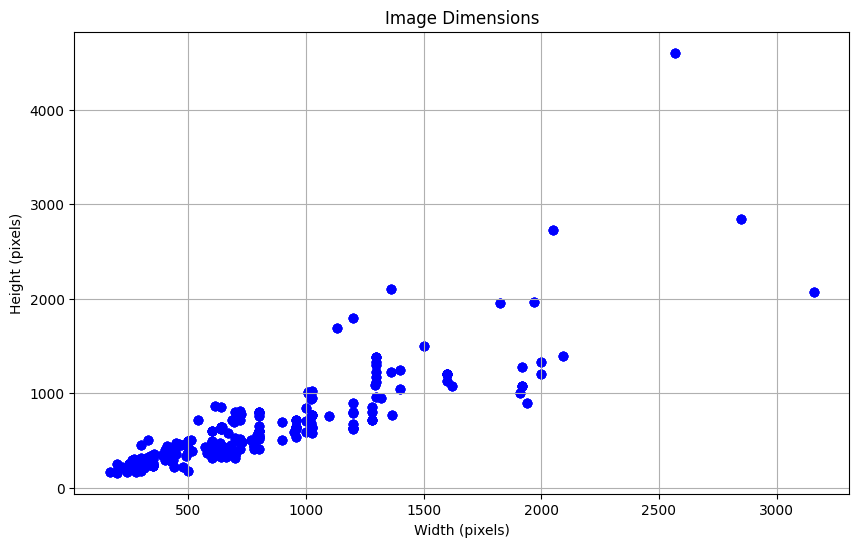

,filename,width,height


In [130]:
plt.figure(figsize=(10, 6))
plt.scatter(image_files_df['width'], image_files_df['height'], color='blue', marker='o')

plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)

plt.show()

image_files_df[image_files_df['height'] == 0]

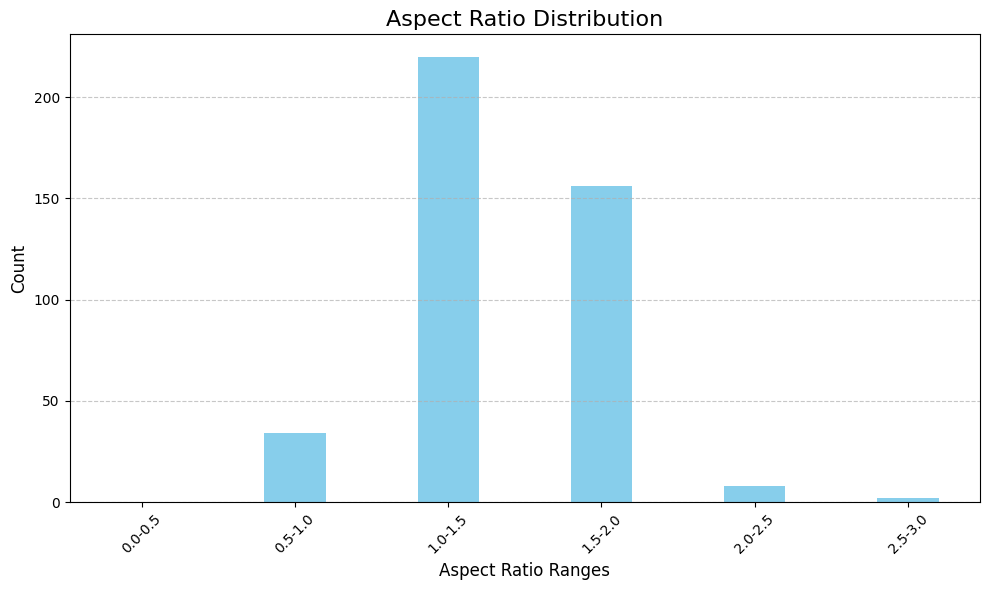

In [112]:
aspect_ratios = df['width'] / df['height']
max_aspect_ratio = aspect_ratios.max()

aspect_ratio_bins = np.arange(0, max_aspect_ratio + 0.5, 0.5)
aspect_ratio_labels = [f"{aspect_ratio_bins[i]}-{aspect_ratio_bins[i+1]}" for i in range(len(aspect_ratio_bins) - 1)]
aspect_ratio_counts, _ = np.histogram(aspect_ratios, aspect_ratio_bins)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(aspect_ratio_labels, aspect_ratio_counts, width=0.4, color='skyblue')
ax.set_xlabel('Aspect Ratio Ranges', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Aspect Ratio Distribution', fontsize=16)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


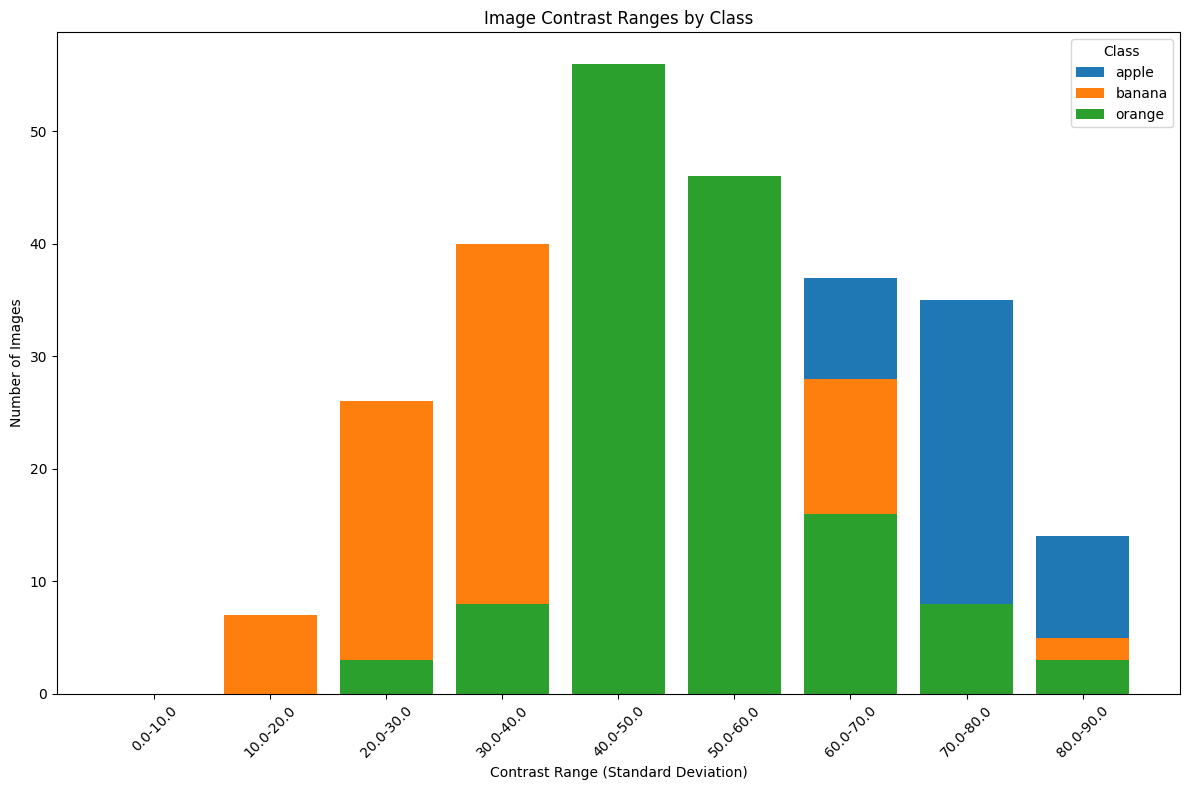

In [116]:
def calculate_contrast(image_path):
    full_path = f"{dataset_folder}/{image_path}"
    image = cv2.imread(full_path)
    if image is None: 
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = gray_image.std()  # Standard deviation of pixel intensities (contrast)
    return contrast

df['contrast'] = df['filename'].apply(calculate_contrast)
df = df.dropna(subset=['contrast'])

max_contrast = df['contrast'].max()
contrast_bins = np.arange(0, max_contrast + 0.5, 10)
contrast_labels = [f"{contrast_bins[i]}-{contrast_bins[i+1]}" for i in range(len(contrast_bins) - 1)]

df['contrast_range'] = pd.cut(df['contrast'], bins=contrast_bins, labels=contrast_labels, right=False)

plt.figure(figsize=(12, 8))

for class_name, group in df.groupby('class'):
    contrast_counts = group['contrast_range'].value_counts().sort_index()
    plt.bar(contrast_counts.index, contrast_counts.values, label=class_name)

plt.title('Image Contrast Ranges by Class')
plt.xlabel('Contrast Range (Standard Deviation)')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


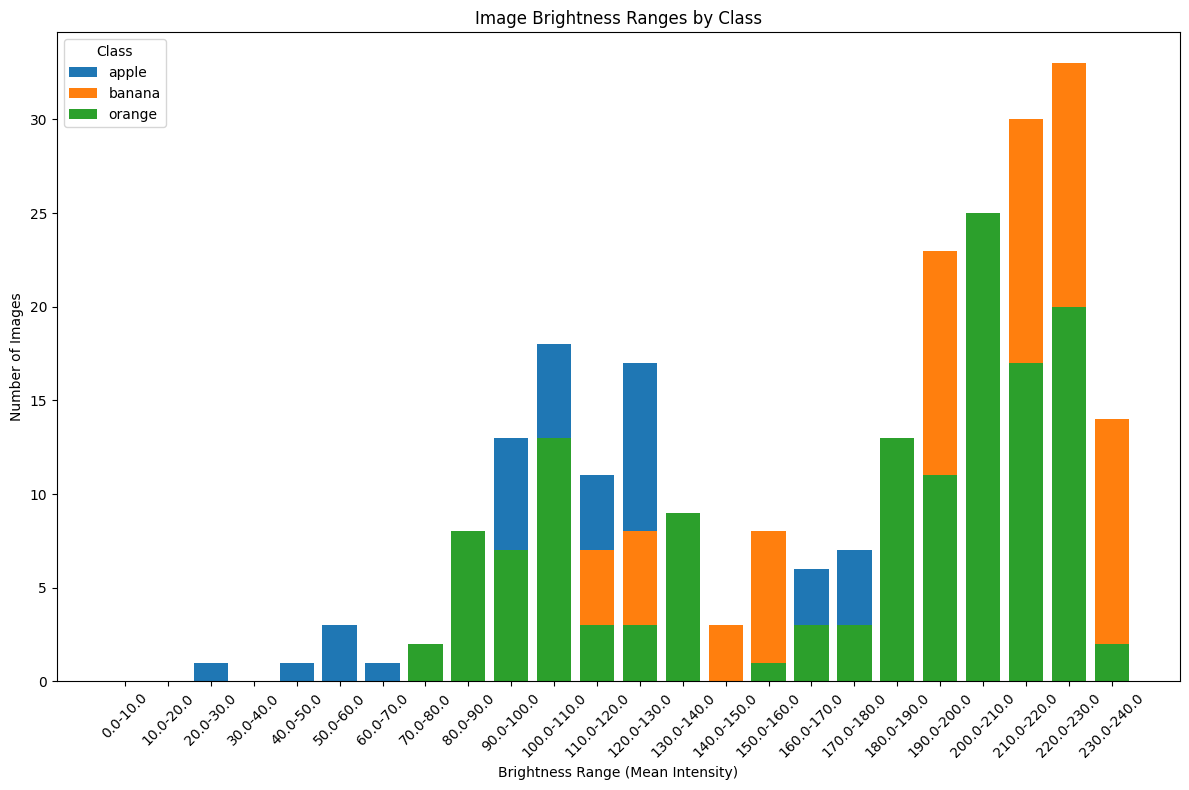

In [115]:
def calculate_brightness(image_path):
    full_path = f"{dataset_folder}/{image_path}"
    image = cv2.imread(full_path)
    if image is None: 
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = gray_image.mean()
    return brightness

df['brightness'] = df['filename'].apply(calculate_brightness)
df = df.dropna(subset=['brightness'])

max_brightness = df['brightness'].max()
brightness_bins = np.arange(0, max_brightness + 0.5, 10)
brightness_labels = [f"{brightness_bins[i]}-{brightness_bins[i+1]}" for i in range(len(brightness_bins) - 1)]

df['brightness_range'] = pd.cut(df['brightness'], bins=brightness_bins, labels=brightness_labels, right=False)

plt.figure(figsize=(12, 8))

for class_name, group in df.groupby('class'):
    brightness_counts = group['brightness_range'].value_counts().sort_index()
    plt.bar(brightness_counts.index, brightness_counts.values, label=class_name)

plt.title('Image Brightness Ranges by Class')
plt.xlabel('Brightness Range (Mean Intensity)')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [50]:
'''
Висновки: 
1. В датасеті є 90 картинок з невизначеними значеннями width та height. 
Під час препроцесінгу потрібно ухвалити рішення щодо їх включення до датасету
2. Картинки с шириною 2000+ пікселів та висотою 1500+ пікселів - потенційні аутлаєри.
3. Картинки з aspect ratio 0-1 та 2+ - потенційні аутлаєри.
4. Майже всі картинки з низькою контрасністю - банани
5. Необхідно перевірити кореляцію між характеристиками зображень (розміри, контрастність, aspect ratio) 
і їх впливом на точність моделі, щоб виявити найбільш значущі параметри для подальшого навчання
6. 
Слід подумати про використання аугментації даних, щоб зробити зображення різноманітнішими. 
Це особливо важливо для зображень з низькою контрасністю та незвичними пропорціями, 
оскільки це може покращити загальні результати моделі.
'''

'\nВисновки: \n1. В датасеті є 90 картинок з невизначеними значеннями width та height. \nПід час препроцесінгу потрібно ухвалити рішення щодо їх включення до датасету\n2. Картинки с шириною 2000+ пікселів та висотою 1500+ пікселів - потенційні аутлаєри.\n3. Картинки з aspect ratio 0-1 та 2+ - потенційні аутлаєри.\n4. Майже всі картинки з низькою контрасністю - банани\n5. Необхідно перевірити кореляцію між характеристиками зображень (розміри, контрастність, aspect ratio) \nі їх впливом на точність моделі, щоб виявити найбільш значущі параметри для подальшого навчання\n6. \nСлід подумати про використання аугментації даних, щоб зробити зображення різноманітнішими. \nЦе особливо важливо для зображень з низькою контрасністю та незвичними пропорціями, \nоскільки це може покращити загальні результати моделі.\n'